In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from mosqlient.models.score import Scorer
#pd.options.mode.chained_assignment = None

# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'

In [2]:
states_BR = ['AL',
 'BA',
 'CE',
 'MA',
 'PB',
 'PE',
 'PI',
 'SE',
 'RN',
 'SP',
 'MG',
 'RJ',
 'ES',
 'AM',
 'AP',
 'TO',
 'RR',
 'RO',
 'AC',
 'PA',
 'DF',
 'GO',
 'MT',
 'MS',
 'RS',
 'SC',
 'PR']

In [3]:
def get_preds(state, label): 
    with open(f'./predictions/lstm_{state}_dengue_{label}.pkl', 'rb') as file:
        data = pickle.load(file)

    indice = data['indice']
    split_point = data['split_point']
    Ydata = data['target']
    df_predicted = data['pred']
    df_predicted25 = data['lb']
    df_predicted975 = data['ub']
        
    data_test = pd.DataFrame()
    data_test.loc[:, 'date'] =  indice[split_point + len(indice)-Ydata.shape[0]:]
    data_test.loc[:,'casos'] = Ydata[split_point:, -1]
    data_test.loc[:,'pred'] = df_predicted.iloc[split_point:,-1].values
    data_test.loc[:,'lower'] =  df_predicted25[df_predicted25.columns[-1]][split_point:].values
    data_test.loc[:,'upper'] = df_predicted975[df_predicted975.columns[-1]][split_point:].values
    
    return data_test


PLOT THE PREDICTIONS VS DATA:

In [8]:
state = 'AL'

label1 = 'att'
label2 = 'att_'
df1 = get_preds(state, label1)
df2 = get_preds(state, label2)

score1 = Scorer(df_true = df1[['date', 'casos']].copy(), pred = df1[['date', 'lower', 'pred', 'upper']].copy(),
               confidence_level=0.95)

score2 = Scorer(df_true = df2[['date', 'casos']].copy(), pred = df2[['date', 'lower', 'pred', 'upper']].copy(),
               confidence_level=0.95)



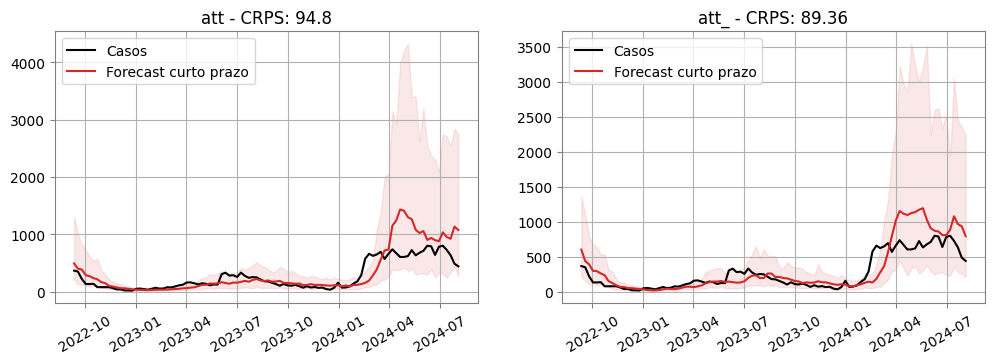

In [5]:

fig,ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(df1.date, df1.casos, color = 'black', label = 'Casos')
    
ax[0].plot(df1.date,  df1.pred, color = 'tab:red', label = 'Forecast curto prazo')
    
ax[0].fill_between(df1.date, df1.lower, df1.upper, color = 'tab:red', alpha = 0.1)
    
ax[0].legend()
ax[0].grid()
ax[0].set_title(f'{label1} - CRPS: {round(score1.crps[1]['pred'],2)}')


ax[1].plot(df2.date, df2.casos, color = 'black', label = 'Casos')
    
ax[1].plot(df2.date,  df2.pred, color = 'tab:red', label = 'Forecast curto prazo')
    
ax[1].fill_between(df2.date, df2.lower, df2.upper, color = 'tab:red', alpha = 0.1)
    
ax[1].legend()
ax[1].grid()
ax[1].set_title(f'{label2} - CRPS: {round(score2.crps[1]['pred'],2) }')

fig.autofmt_xdate(rotation=30, ha='center')
plt.show()


In [6]:
df_score = pd.DataFrame()

for state in states_BR:

    data_test = get_preds(state, 'base')

    score = Scorer(df_true = data_test[['date', 'casos']], pred = data_test[['date', 'lower', 'pred', 'upper']],
               confidence_level=0.95)
    
    score_base = score.crps[1]['pred'] 

    data_test = get_preds(state, 'att')

    score = Scorer(df_true = data_test[['date', 'casos']], pred = data_test[['date', 'lower', 'pred', 'upper']],
               confidence_level=0.95)

    score_att = score.crps[1]['pred'] 

    df_score = pd.concat([df_score, pd.DataFrame([[state, score_base, score_att]], columns = ['state', 'base', 'att'])],
                        ignore_index = True)


/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/core/crps/_closed.py:26: RuntimeWarning: divide by zero encountered in divide
  ω = (obs - mu) / sigma
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/core/crps/_closed.py:26: RuntimeWarning: invalid value encountered in divide
  ω = (obs - mu) / sigma
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/core/crps/_closed.py:27: RuntimeWarning: invalid value encountered in multiply
  return sigma * (
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/core/crps/_closed.py:26: RuntimeWarning: divide by zero encountered in divide
  ω = (obs - mu) / sigma
/opt/homebrew/Caskroom/miniforge/base/envs/lstm_infodengue_sprint/lib/python3.12/site-packages/scoringrules/core/crps/_closed.py:26: RuntimeWarning: invalid value

In [7]:
df_score.loc[df_score.base < df_score.att].state.values

array(['BA', 'CE', 'PI', 'SP', 'MG', 'PA', 'MT', 'SC'], dtype=object)

In [8]:
df_score.loc[df_score.base >= df_score.att].state.values

array(['AL', 'MA', 'PB', 'PE', 'SE', 'RN', 'RJ', 'AM', 'AP', 'TO', 'RR',
       'RO', 'AC', 'DF', 'GO', 'MS', 'RS', 'PR'], dtype=object)

Validação para alguns estados: 

Os modelos foram treinados com os dados entre 2015-01-01 e 2022-09-04. 

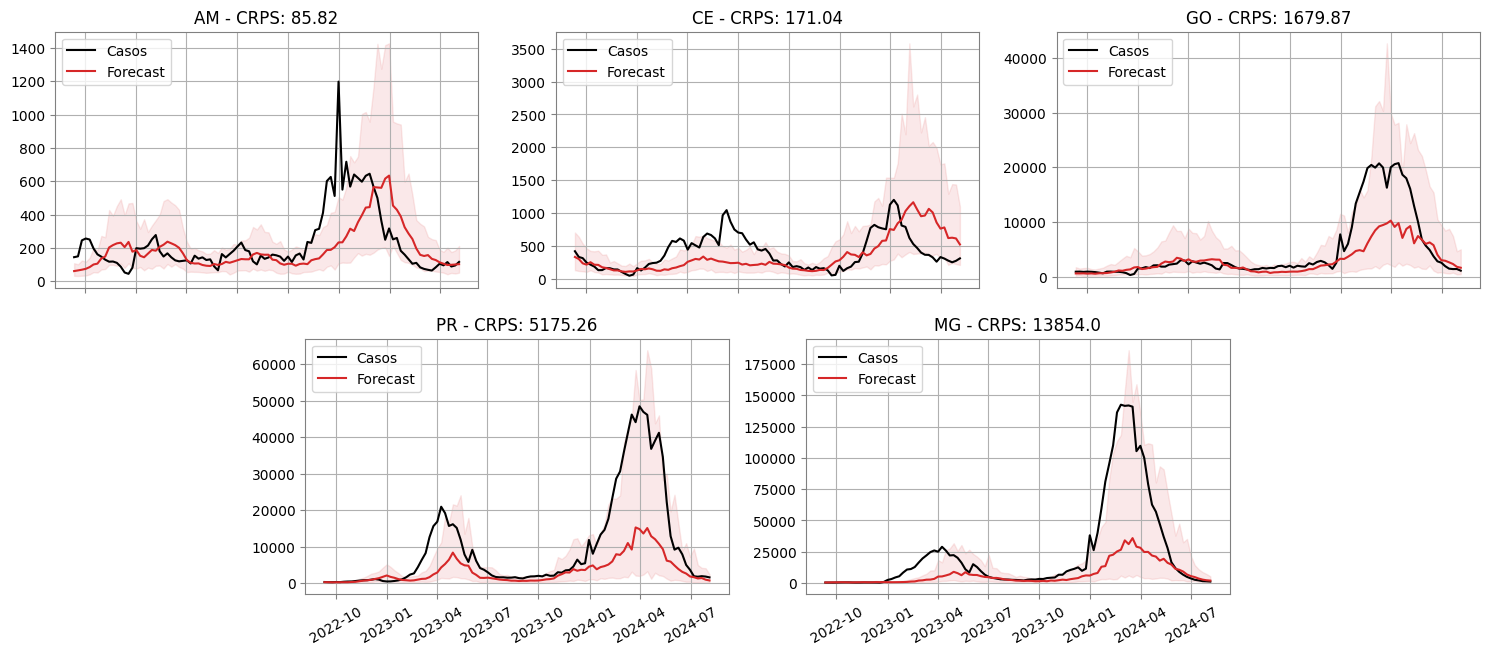

In [11]:
fig = plt.figure(figsize=(15, 7.5))
gs = gridspec.GridSpec(2, 6, figure=fig)
    
# First row with three boxplots
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
    
# Second row with two boxplots
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

i = 0
for state, label, ax  in zip(['AM', 'CE', 'GO', 'PR', 'MG'],
                             ['att', 'base', 'att', 'att', 'base'],
                      [ax1,ax2,ax3,ax4,ax5]): 

    df = get_preds(state, label)


    score1 = Scorer(df_true = df[['date', 'casos']], pred = df[['date', 'lower', 'pred', 'upper']],
               confidence_level=0.95)

    
    ax.plot(df.date, df.casos, color = 'black', label = 'Casos')
        
    ax.plot(df.date,  df.pred, color = 'tab:red', label = 'Forecast')
        
    ax.fill_between(df.date, df.lower, df.upper, color = 'tab:red', alpha = 0.1)
        
    ax.legend()
    ax.grid()
    ax.set_title(f'{state} - CRPS: {round(score1.crps[1]['pred'],2) }')

plt.tight_layout()
fig.autofmt_xdate(rotation=30, ha='center')
plt.show()